In [1]:
import torch
import random
import numpy as np
import torch.utils
import torch.utils.data
from network import create_network, train, test, train_test, testSingleBatch

import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import autograd
from snntorch import spikegen

import matplotlib.pyplot as plt
import os
import dataset

device = torch.device('cuda' if torch.cuda.is_available(
) else 'mps' if torch.backends.mps.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
device

device(type='cuda')

### CREATING PARALIF MODEL

In [3]:
params_stoc = {
    'dataset': 'mnist',
    'input_size': 28*28,
    'nb_class': 10,
    'batch_size': 256,

    'num_steps': 312,
    'hidden_sizes': (128, 32),
    'lr': 0.001,
    'weight_decay': 0.,
    'nb_epochs': 5,
    'loss_mode': 'mean',

    'neuron': "ParaLIF-SB",
    'recurrent': False,
    'tau_mem': 2e-2,
    'tau_syn': 2e-2,
    
    
    'reg_thr': 0.,
    'reg_thr_r': 0.
}

os.chdir('C:/Users/matta/Desktop/Matthew/Uni/Masters/COMPSCI 760/Research Project/biological-neurons')
# MNIST dataset
train_dataset = dataset.CustomDataset(num_steps=params_stoc['num_steps'], dataset=params_stoc['dataset'], train=True)

test_dataset = dataset.CustomDataset(num_steps=params_stoc['num_steps'], dataset=params_stoc['dataset'], train=False)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params_stoc['batch_size'],
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=params_stoc['batch_size'],
                                          shuffle=False)

model_stochastic = create_network(params_stoc, device)


In [4]:
print(model_stochastic)

Sequential(
  (0): ParaLIF(
    spike_mode=SB, recurrent=False, fire=True, alpha=0.95, beta=0.95
    (fc): Linear(in_features=784, out_features=128, bias=True)
    (spike_fn): SpikingFunction()
  )
  (1): ParaLIF(
    spike_mode=SB, recurrent=False, fire=True, alpha=0.95, beta=0.95
    (fc): Linear(in_features=128, out_features=32, bias=True)
    (spike_fn): SpikingFunction()
  )
  (2): ParaLIF(
    spike_mode=SB, recurrent=False, fire=True, alpha=0.95, beta=0.95
    (fc): Linear(in_features=32, out_features=10, bias=True)
    (spike_fn): SpikingFunction()
  )
)


### TRAINING

In [5]:
seed = 1123
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Train_results = train(model_stochastic, train_loader, device=device, nb_epochs=params_stoc['nb_epochs'], loss_mode=params_stoc['loss_mode'], 
                reg_thr=params_stoc['reg_thr'], reg_thr_r=params_stoc['reg_thr_r'], lr=params_stoc['lr'], weight_decay=params_stoc['weight_decay'])

Train 5 epochs: 100%|██████████| 5/5 [12:34<00:00, 150.87s/it, _batch=235/235, accuracy=0.934, loss=0.00625]


### TESTING

Test: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s, accuracy=0.934]


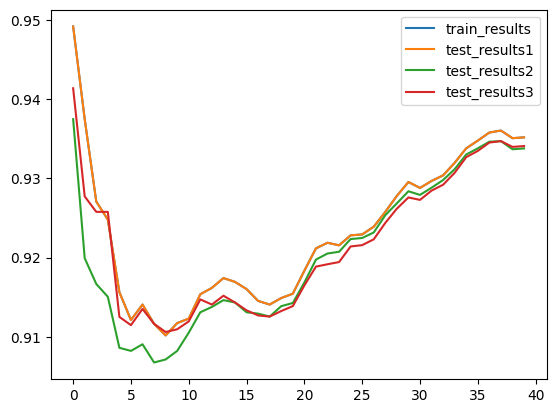

In [6]:
seed = 1123
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

test_results1 = test(model_stochastic, test_loader, device= device, loss_mode=params_stoc['loss_mode'])['acc_list']
test_results2 = test(model_stochastic, test_loader, device= device, loss_mode=params_stoc['loss_mode'])['acc_list']
test_results3 = test(model_stochastic, test_loader, device= device, loss_mode=params_stoc['loss_mode'])['acc_list']

plt.plot(list(range(len(test_results1))), test_results1, label='train_results')
plt.plot(list(range(len(test_results1))), test_results1, label='test_results1')
plt.plot(list(range(len(test_results2))), test_results2, label='test_results2')
plt.plot(list(range(len(test_results3))), test_results3, label='test_results3')
plt.legend() 
plt.show()

## Train-Val per epoch

In [7]:
seed = 1123
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

trin_val_model = create_network(params_stoc, device)

Train_results = train_test(trin_val_model, train_loader, test_loader, device=device, nb_epochs=params_stoc['nb_epochs'], loss_mode=params_stoc['loss_mode'], 
                reg_thr=params_stoc['reg_thr'], reg_thr_r=params_stoc['reg_thr_r'], lr=params_stoc['lr'], weight_decay=params_stoc['weight_decay'])


Epoch: 1/5


Test: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s, accuracy=0.793]



Epoch: 2/5


Test: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s, accuracy=0.904]



Epoch: 3/5


Test: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s, accuracy=0.918]



Epoch: 4/5


Test: 100%|██████████| 40/40 [00:24<00:00,  1.62it/s, accuracy=0.927]



Epoch: 5/5


Test: 100%|██████████| 40/40 [00:24<00:00,  1.61it/s, accuracy=0.934]


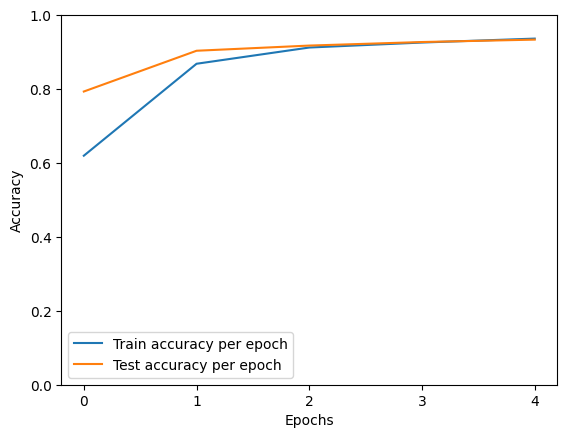

In [8]:
plt.plot(list(range(params_stoc['nb_epochs'])), Train_results[0]['acc'], label='Train accuracy per epoch')
plt.plot(list(range(params_stoc['nb_epochs'])), Train_results[1]['acc'], label='Test accuracy per epoch')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, params_stoc['nb_epochs']))
plt.legend() 
plt.show()

### Showing Stochasticity of Model

In [9]:
params_det = {
    'dataset': 'mnist',
    'input_size': 28*28,
    'nb_class': 10,
    'batch_size': 256,

    'num_steps': 312,
    'hidden_sizes': (128, 32),
    'lr': 0.001,
    'weight_decay': 0.,
    'nb_epochs': 5,
    'loss_mode': 'mean',

    'neuron': "ParaLIF-TT",
    'recurrent': False,
    'tau_mem': 2e-2,
    'tau_syn': 2e-2,
    
    
    'reg_thr': 0.,
    'reg_thr_r': 0.
}

model_deterministic = create_network(params_det, device)

In [10]:
seed = 1123
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Train_results_det = train(model_deterministic, train_loader, device=device, nb_epochs=params_det['nb_epochs'], loss_mode=params_det['loss_mode'], 
                reg_thr=params_det['reg_thr'], reg_thr_r=params_det['reg_thr_r'], lr=params_det['lr'], weight_decay=params_det['weight_decay'])

Train 5 epochs: 100%|██████████| 5/5 [12:57<00:00, 155.49s/it, _batch=235/235, accuracy=0.719, loss=0.00686]


In [11]:
batches = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=params_det['batch_size'], shuffle=False)

single_batch = next(iter(batches))

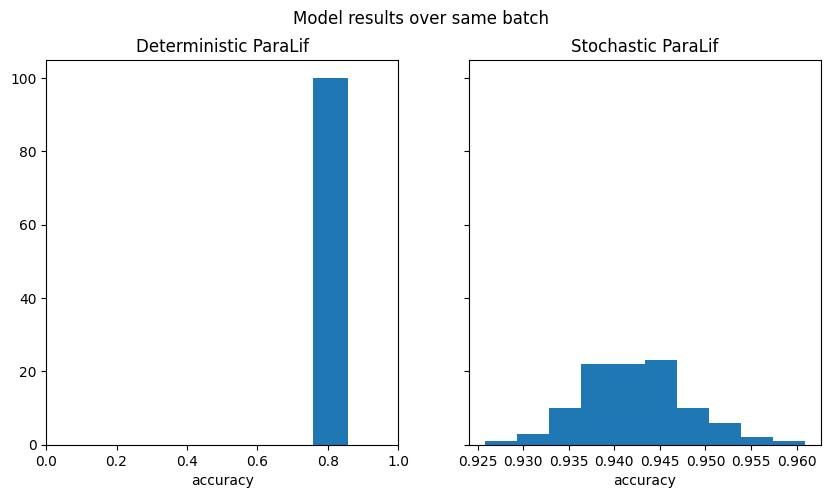

In [12]:
results_stoc = []
results_det = []

for i in range(100):
    results_stoc.append(testSingleBatch(model_stochastic, single_batch, device)['acc'])
    results_det.append(testSingleBatch(model_deterministic, single_batch, device)['acc'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axs[0].hist(results_det)
axs[0].title.set_text('Deterministic ParaLif')
axs[0].set_xlabel('accuracy')
axs[0].set_xlim(0,1)
axs[1].hist(results_stoc, bins= 10)
axs[1].title.set_text('Stochastic ParaLif')
axs[1].set_xlabel('accuracy')
fig.suptitle('Model results over same batch')
plt.show()